In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()

import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict
from wordcloud import STOPWORDS

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from tqdm import tqdm
import re, string
from nltk.stem import PorterStemmer
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

import os
import time

import math

from sklearn import metrics

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D, MaxPool2D, Concatenate, CuDNNLSTM,SpatialDropout1D,GlobalMaxPooling1D,concatenate
from keras.layers import Bidirectional, GlobalMaxPool1D, BatchNormalization
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.initializers import *
from keras.layers.core import Lambda

from keras.layers import *
from keras.models import *
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.initializers import *
from keras.optimizers import *
import keras.backend as K
from keras.callbacks import *
import tensorflow as tf

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tqdm/std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
Using TensorFlow backend.


In [2]:
train = pd.read_csv('train.csv',encoding='latin1')
train

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0
...,...,...,...
1048570,cd76189d120969381147,What info does a Facebook page receive when yo...,0
1048571,cd762e8941f1ab6ae0bf,"If no can know God, why believe in something y...",0
1048572,cd76362e61ce44bcff74,Is it true that the lunar cycle affects women'...,0
1048573,cd763d37d3d7cfcd42ce,What is the difference between the old currenc...,0


In [8]:
# what does toxic text look like?
toxic = train[train['target']==1]

In [9]:
pd.options.display.max_colwidth = 100
print(toxic['question_text'])

22                                         Has the United States become the largest dictatorship in the world?
30                      Which babies are more sweeter to their parents? Dark skin babies or light skin babies?
110        If blacks support school choice and mandatory sentencing for criminals why don't they vote Repub...
114        I am gay boy and I love my cousin (boy). He is sexy, but I dont know what to do. He is hot, and ...
115                                                                       Which races have the smallest penis?
                                                          ...                                                 
1048511                                                   Why are some Asians put so much importance on money?
1048515               Why do many liberals like Hilary over trump? Did she shit gold? Or did I miss something?
1048527    Why do Americans say "she gave birth to a baby girl"? Can you also give birth to a toddler girl,...
1

In [10]:
# ratio of toxic text?
len(toxic) / len(train)

0.061773359082564434

In [13]:
# simple word count for toxic text and non-toxic text
non_toxic = train[train['target'] == 0]

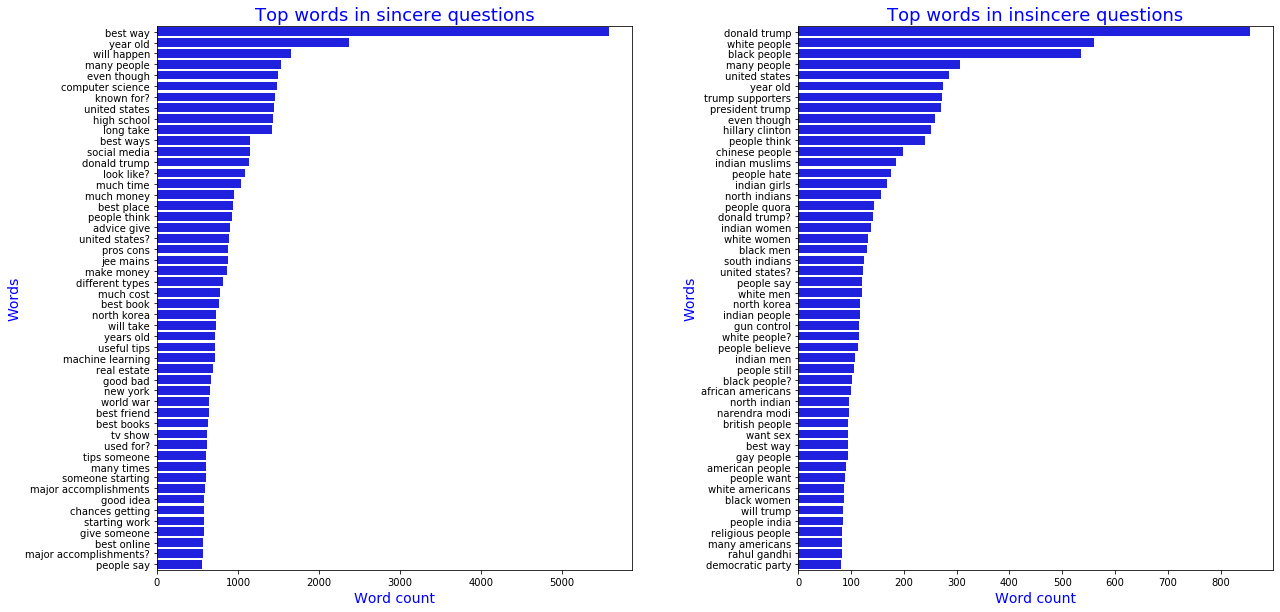

In [16]:
stopwords = set(STOPWORDS)
more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
stopwords = stopwords.union(more_stopwords)

def ngram_extractor(text, n_gram):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

# Function to generate a dataframe with n_gram and top max_row frequencies
def generate_ngrams(df, col, n_gram, max_row):
    temp_dict = defaultdict(int)
    for question in df[col]:
        for word in ngram_extractor(question, n_gram):
            temp_dict[word] += 1
    temp_df = pd.DataFrame(sorted(temp_dict.items(), key=lambda x: x[1])[::-1]).head(max_row)
    temp_df.columns = ["word", "wordcount"]
    return temp_df

def comparison_plot(df_1,df_2,col_1,col_2, space):
    fig, ax = plt.subplots(1, 2, figsize=(20,10))
    
    sns.barplot(x=col_2, y=col_1, data=df_1, ax=ax[0], color="blue")
    sns.barplot(x=col_2, y=col_1, data=df_2, ax=ax[1], color="blue")

    ax[0].set_xlabel('Word count', size=14, color="blue")
    ax[0].set_ylabel('Words', size=14, color="blue")
    ax[0].set_title('Top words in sincere questions', size=18, color="blue")

    ax[1].set_xlabel('Word count', size=14, color="blue")
    ax[1].set_ylabel('Words', size=14, color="blue")
    ax[1].set_title('Top words in insincere questions', size=18, color="blue")

    fig.subplots_adjust(wspace=space)
    
    plt.show()
    
sincere_gram = generate_ngrams(non_toxic, 'question_text', 2, 50)
insincere_gram = generate_ngrams(toxic, 'question_text', 2, 50)
comparison_plot(sincere_gram,insincere_gram,'word','wordcount', .35)

# Logistic Regression

In [17]:
validation = train.sample(frac=0.1, replace=False, weights=None, random_state=None, axis=None)
validation.head()

,qid,question_text,target
809415,9e9eb8f6edf76549f2eb,Why must there be a right and wrong?,0
347054,43fef130f1656d432491,Can I use single domain for blog and website?,0
808087,9e57726be8dd2b3e2d7d,"If you have both adopted and biological children, do you discipline them differently?",0
628753,7b205b26a438af15bb1b,"Does it mean the person has also saved my contact if I have the option to ""FaceTime"" with her?",0
731112,8f2d783cc4c2e0a341f4,What is your honest salary in marketing?,0


In [18]:
train = train[~train.index.isin(validation.index)]
train.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province as a nation in the 1960s?,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you encourage people to adopt and not shop?",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity affect space geometry?,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg hemispheres?,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain bike by just changing the tyres?,0


In [19]:
# cleaning insignificant symbols
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’""])')

In [20]:
# Tokenize function
def tokenize(s): 
    s= re.sub('[^a-zA-Z0-9]'," ",s)
    tokens=re_tok.sub(r' \1',s).split()
    return tokens

In [21]:
n = train.shape[0]
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
                     min_df=3, max_df=0.9, strip_accents='unicode',
                     use_idf=1, smooth_idf=1, sublinear_tf=1)

In [23]:
# Calculate TF-IDF weight
trn_term_doc = vec.fit_transform(train['question_text'])
val_term_doc = vec.transform(validation['question_text'])

In [16]:
x = trn_term_doc
x_val = val_term_doc

In [17]:
# Generate a Logistic Regression model
def get_model(y):
    y = y.values
    m = LogisticRegression(C=4, dual=False,solver='liblinear')    
    return m.fit(x, y)

In [18]:
preds = np.zeros((len(validation), 1))
labels_cols=['target']

In [19]:
m= get_model(train['target'])
preds = m.predict_proba(x_val)[:,1]

In [20]:
# Calculate auc and draw ROC curve
y_true = validation['target'].values
y_score = preds
fpr, tpr, thresholds=roc_curve(y_true,y_score)
roc_auc =auc(fpr, tpr) 
roc_auc

0.9588429524256985

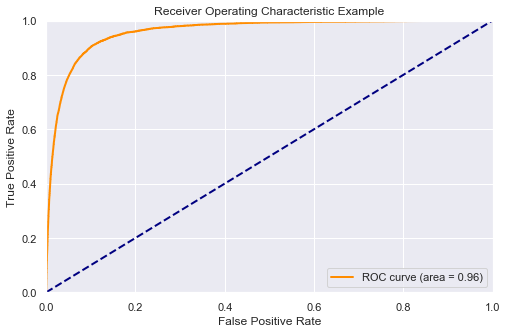

In [21]:
lw = 2
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Example')
plt.legend(loc="lower right")
plt.show()

In [22]:
result = np.zeros((len(validation), 1))
for i in range(len(preds)):
    if preds[i] > 0.47:
        result[i]=1
    else:
        result[i]=0

In [23]:
# Calculate precision
val=validation['target'].values
val.reshape(preds.shape)
temp=0
for i in range(len(val)):
    if result[i]==val[i]:
        temp+=1
precision = temp/len(val)
precision

0.9560930019645616

In [24]:
result_2 = np.zeros((len(validation), 1))
# Calculate F1 score
for i in range(len(preds)):
    if preds[i] > 0.25:
        result_2[i]=1
    else:
        result_2[i]=0

b=np.sum(result_2)
a = np.sum(val)
c=0
for i in range(len(val)):
    if result_2[i]==1 and val[i]==1:
        c+=1
precision = c / b
recall = c / a
f1_score = 2 * precision * recall / (precision + recall)
f1_score



0.6402524544179523

# Embeddings

In [8]:
embed_size = 300 
max_features = 50000
maxlen = 100


train_X = train["question_text"].fillna("_na_").values
val_X = validation["question_text"].fillna("_na_").values


## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))#size
train_X = tokenizer.texts_to_sequences(train_X)
val_X = tokenizer.texts_to_sequences(val_X)

train_X = pad_sequences(train_X, maxlen=maxlen)
val_X = pad_sequences(val_X, maxlen=maxlen)

train_y = train['target'].values
val_y = validation['target'].values


### Embedding

def embedding_dic(path):
    EMBEDDING_FILE = path

    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE, encoding="utf8", errors='ignore') if len(o)>100)

    return embeddings_index


embeddings_index_gl = embedding_dic('glove.840B.300d.txt')
embeddings_index = embeddings_index_gl

print(len(embeddings_index),embeddings_index['UNK'].shape)
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))

# compute embedding matrix & solving the uncovered words
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

2196016 (300,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


# Build model

In [9]:
# two layers GRU

inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(CuDNNGRU(128, return_sequences=True))(x)
x = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x) 
x = Dense(64, activation="relu")(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)


model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam')
print(model.summary())


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 300)          15000000  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 256)          330240    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 128)          123648    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)      

In [0]:
# BiLSTM+CNN

filters=[100, 80, 30, 12]    
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=False)(inp)
x = Bidirectional(CuDNNLSTM(128, return_sequences=True, 
                           kernel_initializer=glorot_uniform(), 
                           recurrent_initializer=Orthogonal(gain=1.00)))(x)
x = BatchNormalization()(x)
x1 = Conv1D(filters=filters[0], activation='relu', kernel_size=1, 
            padding='same', kernel_initializer=glorot_uniform())(x)
x2 = Conv1D(filters=filters[1], activation='relu', kernel_size=2, 
            padding='same', kernel_initializer=glorot_uniform())(x)
x3 = Conv1D(filters=filters[2], activation='relu', kernel_size=3, 
            padding='same', kernel_initializer=glorot_uniform())(x)
x4 = Conv1D(filters=filters[3], activation='relu', kernel_size=5, 
            padding='same', kernel_initializer=glorot_uniform())(x)


x1 = GlobalMaxPool1D()(x1)
x2 = GlobalMaxPool1D()(x2)
x3 = GlobalMaxPool1D()(x3)
x4 = GlobalMaxPool1D()(x4)

c = concatenate([x1, x2, x3, x4])
x = Dense(200, activation='relu', kernel_initializer=glorot_uniform())(c)
x = BatchNormalization()(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(16, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(1, activation="sigmoid", kernel_initializer=glorot_uniform())(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 100, 300)     15000000    input_8[0][0]                    
__________________________________________________________________________________________________
bidirectional_17 (Bidirectional (None, 100, 256)     440320      embedding_8[0][0]                
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 100, 256)     1024        bidirectional_17[0][0]           
__________________________________________________________________________________________________
conv1d_1 (

In [10]:
model.fit(train_X, train_y, batch_size=256, epochs=2, validation_data=(val_X, val_y))

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 1044909 samples, validate on 130600 samples
Epoch 1/2
1044909/1044909 [==============================] - 270s 258us/step - loss: 0.1097 - val_loss: 0.1000
Epoch 2/2
1044909/1044909 [==============================] - 266s 255us/step - loss: 0.0909 - val_loss: 0.1008


In [11]:
pred_noemb_val_y = model.predict([val_X], batch_size=1024, verbose=1)
pred_noemb_val_y

130600/130600 [==============================] - 8s 59us/step


array([[0.01810017],
       [0.0043821 ],
       [0.00049815],
       ...,
       [0.03954193],
       [0.00051263],
       [0.00469738]], dtype=float32)

In [30]:
# compute F1 score and Accuracy

acc =0
f1 = 0
for thresh in np.arange(0.1, 0.99, 0.01):
    thresh = np.round(thresh, 2)
    if metrics.accuracy_score(val_y, (pred_noemb_val_y>thresh).astype(int))>acc:
        print("Accuracy at threshold {0} is {1}".format(thresh, metrics.accuracy_score(val_y, (pred_noemb_val_y>thresh).astype(int))))
        acc = metrics.accuracy_score(val_y, (pred_noemb_val_y>thresh).astype(int))
    if metrics.f1_score(val_y, (pred_noemb_val_y>thresh).astype(int))>f1:
        print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(val_y, (pred_noemb_val_y>thresh).astype(int))))
        f1 = metrics.f1_score(val_y, (pred_noemb_val_y>thresh).astype(int))
    

Accuracy at threshold 0.1 is 0.9303522205206738
F1 score at threshold 0.1 is 0.6083024717939886
Accuracy at threshold 0.11 is 0.9329632465543645
F1 score at threshold 0.11 is 0.6156885123567885
Accuracy at threshold 0.12 is 0.9349846860643185
F1 score at threshold 0.12 is 0.6211573640298041
Accuracy at threshold 0.13 is 0.9369831546707503
F1 score at threshold 0.13 is 0.6267573696145124
Accuracy at threshold 0.14 is 0.9389433384379786
F1 score at threshold 0.14 is 0.6329743164871582
Accuracy at threshold 0.15 is 0.940666156202144
F1 score at threshold 0.15 is 0.6382859543481305
Accuracy at threshold 0.16 is 0.9417993874425727
F1 score at threshold 0.16 is 0.6417833074131675
Accuracy at threshold 0.17 is 0.9430781010719755
F1 score at threshold 0.17 is 0.6454597481877147
Accuracy at threshold 0.18 is 0.9443491577335376
F1 score at threshold 0.18 is 0.6493293447843288
Accuracy at threshold 0.19 is 0.9455130168453293
F1 score at threshold 0.19 is 0.6530811232449298
Accuracy at threshold 0